<a href="https://colab.research.google.com/github/URBAN-IA/URBANIA/blob/main/study/SHAP_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color=white> 06.SHAP Code 실습**

[목적]
  - Global Importance Score와 Local Importance Score 계산
  - SHAP Page 활용 Locality 실습

[Process]
  1. Define X's & Y
  2. Split Train & Valid dataset
  3. Modeling
  4. Model 해석
  5. Black Box 해석

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 7.6 MB/s eta 0:00:00


In [ ]:
import os
import gc
import re
import pickle
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter

In [ ]:
# Data Loading (수술 時 사망 데이터)
data=pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")
# Data Checking
col = []
missing = []
level = []
for name in data.columns:

    # Missing
    missper = data[name].isnull().sum() / data.shape[0]
    missing.append(round(missper, 4))

    # Leveling
    lel = data[name].dropna()
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

summary = pd.concat([pd.DataFrame(col, columns=['name']),
                     pd.DataFrame(missing, columns=['Missing Percentage']),
                     pd.DataFrame(level, columns=['Level'])], axis=1)

drop_col = summary['name'][(summary['Level'] <= 1) | (summary['Missing Percentage'] >= 0.8)]
data.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data.shape))


>>>> Data Shape : (532, 22)


In [ ]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(Y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(Y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 241, 1: 131})
>>>> # of valid data Y : Counter({0: 110, 1: 50})


In [ ]:
# n_estimators
n_tree = [5, 10, 20]
# learning_rate
l_rate = [0.1, 0.3]
# max_depth
m_depth = [3, 5]
# reg_alpha
L1_norm = [0.1, 0.3, 0.5]

# Modeling
save_n = []
save_l = []
save_m = []
save_L1 = []
f1_score_ = []

cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:

                print(">>> {} <<<".format(cnt))
                cnt +=1
                print("n_estimators : {}, learning_rate : {}, max_depth : {}, reg_alpha : {}".format(n, l, m, L1))
                model = LGBMClassifier(n_estimators=n, learning_rate=l,
                                       max_depth=m, reg_alpha=L1,
                                       n_jobs=-1, objective='cross_entropy')
                model.fit(X.iloc[train_idx], Y.iloc[train_idx])


                # Train Acc
                y_pre_train = model.predict(X.iloc[train_idx])
                cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
                print("Train Confusion Matrix")
                print(cm_train)
                print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
                print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

                # Test Acc
                y_pre_test = model.predict(X.iloc[valid_idx])
                cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
                print("Test Confusion Matrix")
                print(cm_test)
                print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
                print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n.append(n)
                save_l.append(l)
                save_m.append(m)
                save_L1.append(L1)
                f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))


                #joblib.dump(model, './LightGBM_model/Result_{}_{}_{}_{}_{}.pkl'.format(n, l, m, L1, round(save_acc[-1], 4)))
                #gc.collect()
print(">>> {} <<<\nBest Test f1-score : {}\nBest n_estimators : {}\nBest Learning Rate : {}\nBest Max_depth : {}\nBest L1-norm : {}".format(np.argmax(f1_score_),
                                                                                                                                            f1_score_[np.argmax(f1_score_)],
                                                                                                                                            save_n[np.argmax(f1_score_)],
                                                                                                                                            save_l[np.argmax(f1_score_)],
                                                                                                                                            save_m[np.argmax(f1_score_)],
                                                                                                                                            save_L1[np.argmax(f1_score_)]))
best_model = LGBMClassifier(n_estimators=save_n[np.argmax(f1_score_)], learning_rate=save_l[np.argmax(f1_score_)],
                           max_depth=save_m[np.argmax(f1_score_)], reg_alpha=save_L1[np.argmax(f1_score_)], objective='cross_entropy',
                           random_state=119)
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))

>>> 0 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.1
Train Confusion Matrix
[[237   4]
 [ 55  76]]
Train Acc : 0.8413978494623656
Train F1-Score : 0.7203791469194314
Test Confusion Matrix
[[103   7]
 [ 10  40]]
TesT Acc : 0.89375
Test F1-Score : 0.8247422680412372
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.3
Train Confusion Matrix
[[237   4]
 [ 54  77]]
Train Acc : 0.8440860215053764
Train F1-Score : 0.7264150943396226
Test Confusion Matrix
[[102   8]
 [ 10  40]]
TesT Acc : 0.8875
Test F1-Score : 0.816326530612245
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.5
Train Confusion Matrix
[[237   4]
 [ 54  77]]
Trai

    Score  Feature
0      12    event
1       5     cd40
2       4    cd420
3       3  preanti
4       3    cd496
5       2     race
6       1     wtkg
7       1      age
8       0      z30
9       0  symptom
10      0    strat
11      0     str2
12      0        r
13      0   oprior
14      0   karnof
15      0     homo
16      0     hemo
17      0   gender
18      0    drugs
19      0    cd820
20      0     cd80


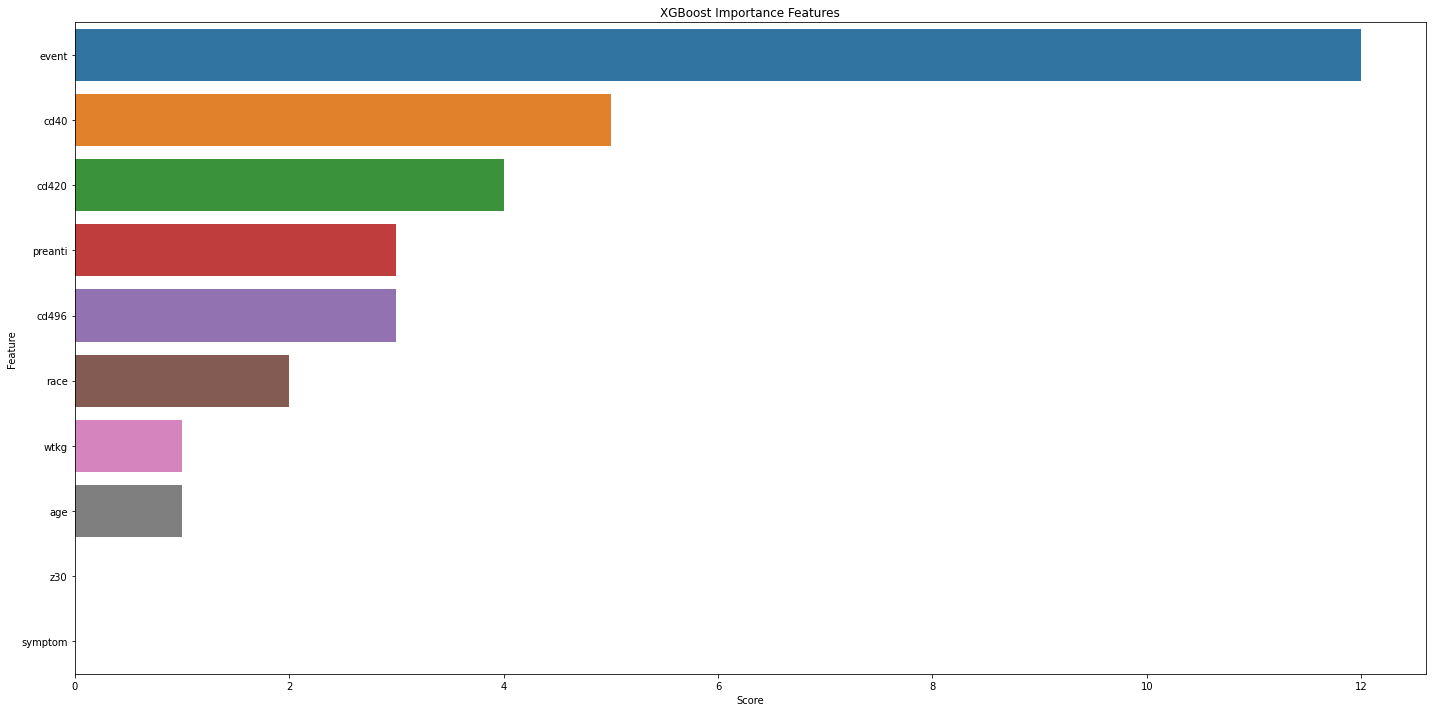

In [ ]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)
# Importance Score Top 10
feature_map_10 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_10.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('XGBoost Importance Features')
plt.tight_layout()
plt.show()

[SHAPely Values]
  - Package : https://shap.readthedocs.io/en/latest/
  - Package Code & Example : https://github.com/slundberg/shap

[SHAPely Values 내장 함수]
  - force_plot : 특정 데이터 하나 또는 전체 데이터에 대해 Shapley value를 1차원 평면에 정렬하여 보여주는 Plot
  - dependence_plot : 각 특성의 Shapely Value를 확인할 수 있음
    - y축에 나온 특성은 선택한 x와의 관계(상호작용 효과)를 나타냄, 그래프 상에서 색깔이 수직 패턴이 나오는 경우 관계가 존재한다고 판단할 수 잇음
  - Summary_plot : Global하게 Shapely value를 보여주는 plot
    - shapely value 분포에 어떤 영향을 미치는지 시각화 해줌
    - shap_interaction_values : X's 간 관계 (상관관계)를 파악할 수 있는 Plot

[SHAPely Values 주의 사항]
  1. Shapely Values를 계산할 때 시간이 오래걸림
  2. 데이터가 크면 클수록 시간이 많이 걸리기 때문에 원하는 Index만 추출하여 계산하는 것을 추천함
  3. 현재 데이터는 많지 않기 때문에 전체에 대해서 진행할 예정

[TreeExplainer]
  - While SHAP can explain the output of any machine learning model, we have developed a high-speed exact algorithm for tree ensemble methods (see our Nature MI paper). Fast C++ implementations are supported for XGBoost, LightGBM, CatBoost, scikit-learn and pyspark tree models
  
[GradientExplainer]
  - Expected gradients combines ideas from Integrated Gradients, SHAP, and SmoothGrad into a single expected value equation. This allows an entire dataset to be used as the background distribution (as opposed to a single reference value) and allows local smoothing. If we approximate the model with a linear function between each background data sample and the current input to be explained, and we assume the input features are independent then expected gradients will compute approximate SHAP values. In the example below we have explained how the 7th intermediate layer of the VGG16 ImageNet model impacts the output probabilities.

[KernelExplainer] - 시간 엄청 오래 걸림...
  - Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model. Below is a simple example for explaining a multi-class SVM on the classic iris dataset.



In [ ]:
# SHAP Explainer 만들기
explainer = shap.TreeExplainer(best_model)
# Shap values 계산
shap_values = explainer.shap_values(X.iloc[train_idx])

In [ ]:
X.iloc[train_idx].shape

(372, 21)

In [ ]:
shap_values.shape

(372, 21)

In [ ]:
#force_plot : 특정 데이터 하나 또는 전체 데이터에 대해 Shapley value를 1차원 평면에 정렬하여 보여주는 Plot
# 예시는 첫번째 데이터에 대해
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[2, :], X.iloc[train_idx[2], :], link="logit")

In [ ]:
Y.iloc[train_idx[2]]

1

In [ ]:
# 누적 시각화
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X.iloc[train_idx])

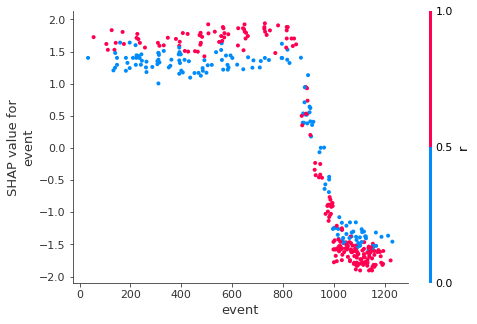

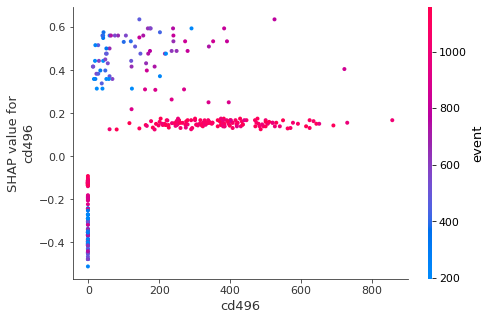

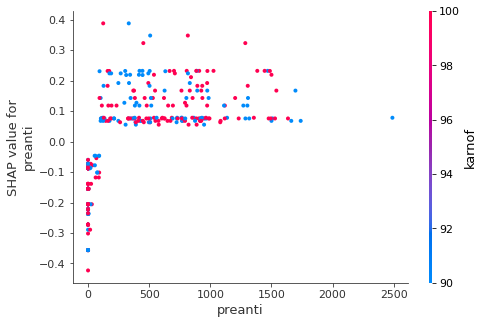

In [ ]:
# Shap Value의 절대 값이 큰 순서대로 정렬함
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
# 영향력 Top 3에 대한 Dependence plot
for i in range(3):
    shap.dependence_plot(top_inds[i], shap_values, X.iloc[train_idx])

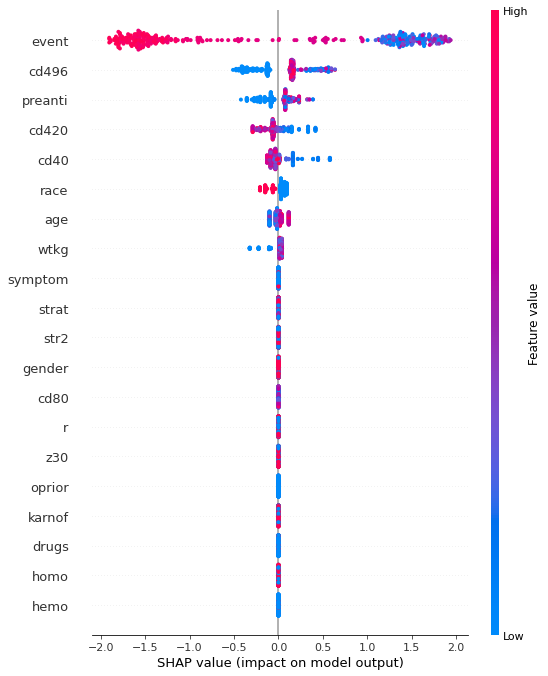

In [ ]:
# Global Importance Score
shap.summary_plot(shap_values, X.iloc[train_idx])

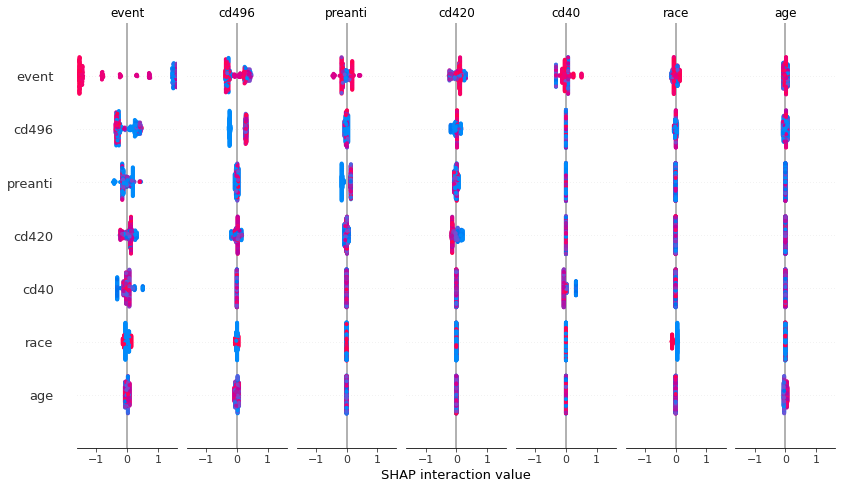

In [ ]:
# Interaction Plot
shap_interaction_values = explainer.shap_interaction_values(X.iloc[train_idx])
shap.summary_plot(shap_interaction_values, X.iloc[train_idx])